In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import pyproj
from matplotlib.collections import PatchCollection
from descartes.patch import PolygonPatch
from pyproj import Proj, transform

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape
import fiona
from fiona.crs import to_string

from itertools import chain

import urllib

import geopandas as gpd

Import habitat model coverage

In [2]:
with fiona.open('data/HabModelEnviro.shp') as shp:
    
    records = list(shp)
    hab_model_bounds = shp.bounds
    hab_model_json = {"type": "FeatureCollection", "features": records}
    hab_model_crs = shp.crs

/usr/local/lib/python3.4/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: Read cursor may be altered. This can lead to side effects
  app.launch_new_instance()


In [3]:
epsg26717_str = urllib.request.urlopen('http://spatialreference.org/ref/epsg/26717/proj4/').read().decode("utf-8")
epsg26717_str

'+proj=utm +zone=17 +ellps=clrk66 +datum=NAD27 +units=m +no_defs '

In [4]:
hab_model_crs

{'init': 'epsg:26717'}

In [5]:
wgs84 = Proj(init='EPSG:4326')

In [6]:
hab_model_proj = Proj(hab_model_crs)

In [7]:
ll = hab_model_bounds[0], hab_model_bounds[1]
ur = hab_model_bounds[2], hab_model_bounds[3]
coords = list(chain(ll, ur))

# Convert to WGS84
coords_wgs = hab_model_proj(*coords[:2], inverse=True) + hab_model_proj(*coords[2:], inverse=True)
w, h = coords_wgs[2] - coords_wgs[0], coords_wgs[3] - coords_wgs[1]

In [8]:
extra = 0.01

southeast = Basemap(ax=None,
    llcrnrlon=coords_wgs[0] - extra * w,
    llcrnrlat=coords_wgs[1] - extra + 0.01 * h,
    urcrnrlon=coords_wgs[2] + extra * w,
    urcrnrlat=coords_wgs[3] + extra + 0.01 * h,
    resolution='i',
    epsg='4326')

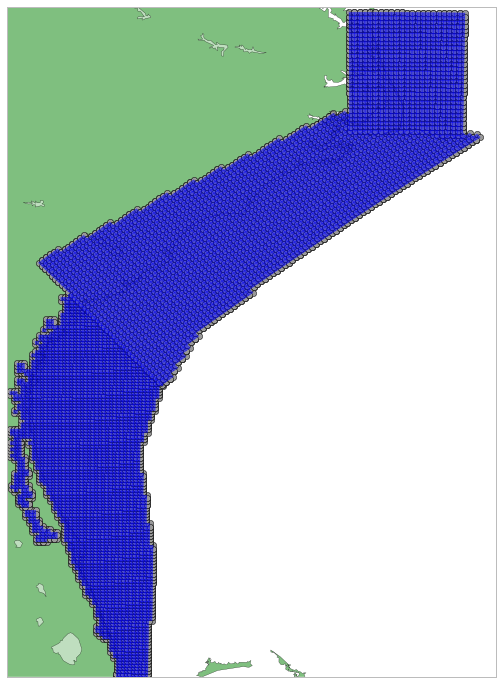

In [9]:
from matplotlib.pyplot import cm, colorbar
#from mpl_toolkits.basemap import Polygon, PolyCollection

fig = plt.figure(figsize=(16,12))
ax = plt.gca()
southeast.drawcoastlines(linewidth=0.25)
southeast.fillcontinents(zorder=-1, color='green', alpha=0.5)

mp = MultiPolygon(
    [shape(pol['geometry']) for pol in fiona.open('data/HabModelEnviro_WGS84.shp')])

# patches = []
# for poly in mp:
#     #colour = cm(1. * len(filter(poly.contains, points)) / num_colours)
#     patches.append(PolygonPatch(poly, fc=colour, ec='#555555', lw=0.2, alpha=1., zorder=1))
# pc = PatchCollection(patches, match_original=True)
# ax.add_collection(pc)

def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, 'o', color='#999999', zorder=1)
    
for polygon in mp:
    plot_coords(ax, polygon.exterior)
    patch = PolygonPatch(polygon, facecolor='blue', edgecolor='blue', alpha=0.5, zorder=2)
    ax.add_patch(patch)

# z = [state_cases[i]*(i!='SAO PAULO') for i in municipio]
# coll = PolyCollection(SP_region.region, array=np.array(z), cmap=cm.Blues, edgecolors='none')
# ax.add_patch(mp)
# colorbar(coll, ax=ax, shrink=0.7)

# sp_poly = Polygon(SP_region.region[municipio.index('SAO PAULO')], facecolor='black')
# ax.add_patch(sp_poly)


plt.show()

Import data to GeoPandas

In [10]:
HabModelEnviro = gpd.GeoDataFrame.from_file('data/HabModelEnviro.shp').replace({-999: None})

In [11]:
WGS84_crs = urllib.request.urlopen('http://spatialreference.org/ref/epsg/4326/proj4/').read().decode("utf-8")

In [12]:
HabModelEnviroWGS84 = HabModelEnviro.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

Truncate to area of interest (31o41' to 33o)

In [64]:
upper_limit = 33
lower_limit = 31.683

In [65]:
HabModelEnviroSC = HabModelEnviroWGS84[(lower_limit < HabModelEnviroWGS84.Lat) & 
                                       (HabModelEnviroWGS84.Lat < upper_limit)]

In [66]:
coords_wgs[2] + extra * w

-73.98715980985588

In [67]:
coords_wgs[0] - extra * w

-81.80591199654882

Import nav channel layer

In [68]:
navchannel = gpd.GeoDataFrame.from_file('data/SHEP_navchannel.shp')

In [69]:
navchannelWGS84 = navchannel.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

In [76]:
basemap_sc = Basemap(ax=None,
    llcrnrlon=-81.5,
    llcrnrlat=lower_limit - extra*w,
    urcrnrlon=-77.5,
    urcrnrlat=upper_limit + extra*w,
    resolution='i',
    epsg='4326')

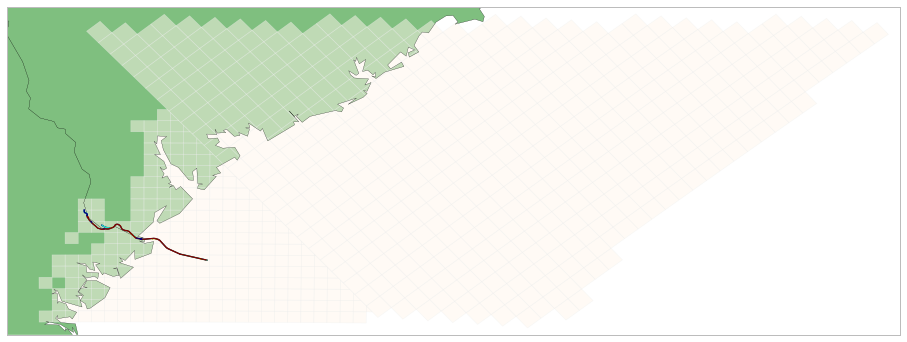

In [81]:
fig = plt.figure(figsize=(16,10))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

HabModelEnviroSC.plot(column='sstmar13b', k=5, colormap='OrRd', linewidth=0, axes=ax)
navchannelWGS84.plot(column='Color', axes=ax)

Import survey data

In [82]:
HabModelSurvey = gpd.GeoDataFrame.from_file('data/HabModelSurvey.shp')

Reproject to GGS84

In [83]:
HabModelSurveyWGS84 = HabModelSurvey.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

Clip to area of interest

In [84]:
HabModelSurveySC = HabModelSurveyWGS84[(lower_limit < HabModelSurveyWGS84.Lat) 
                                       & (HabModelSurveyWGS84.Lat < upper_limit)]

In [85]:
HabModelSurveySC.GrpsJan10B.value_counts()

0    802
1      3
dtype: int64

Colormap for binary features

In [86]:
import matplotlib
binary_cm = matplotlib.colors.ListedColormap(np.array([[255,255,255], [0,0,0]])/255)

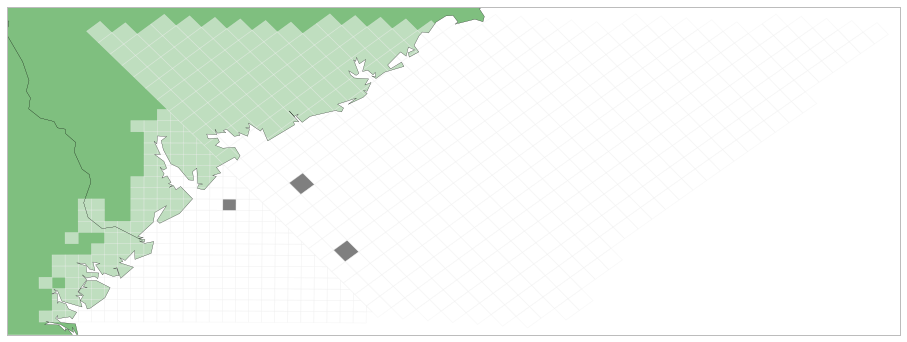

In [87]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

HabModelSurveySC.plot(column='GrpsJan10B', k=2, colormap=binary_cm, linewidth=0, axes=ax)

Perform a merge of survey and habitat data

In [88]:
# Use lower case for trailing A and B times
replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelEnviroSC.columns if c.endswith('A') or c.endswith('B')}
HabModelEnviro_points = HabModelEnviroSC.copy().rename(columns=replace_dict)
HabModelEnviro_points.geometry = HabModelEnviro_points.geometry.centroid

In [139]:
from geopandas.tools import sjoin

replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelSurveySC.columns if c.endswith('A') or c.endswith('B')}
HabModel_merged = sjoin(HabModelSurveySC.rename(columns=replace_dict), HabModelEnviro_points, how="left")

In [141]:
# Drop cells with null DistToShor values (land)
HabModel_merged = HabModel_merged.dropna(subset=['DistToShor'])

SST and whales for an arbitrary month

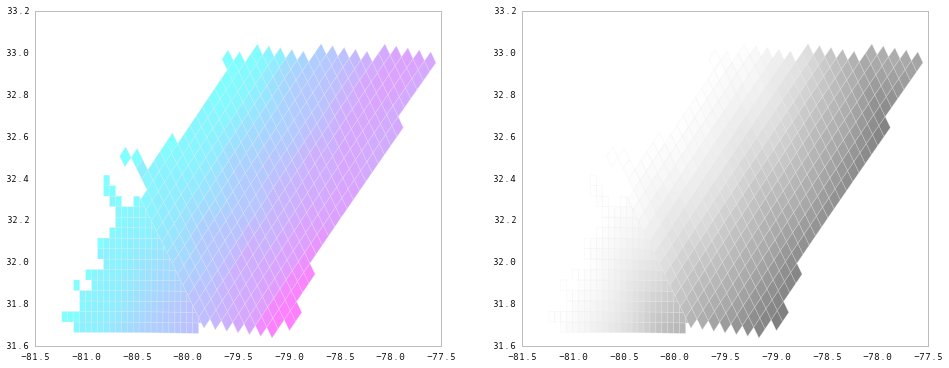

In [142]:
f, axes = plt.subplots(1, 2, figsize=(16, 6))

HabModel_merged.plot(column='sstjan12b', k=8, colormap='cool', linewidth=0, axes=axes[0])

HabModel_merged.plot(column='DistToShor', k=3, colormap='Greys', linewidth=0, axes=axes[1])


Convert data into long format and remove time information from column names. We are breaking the data into one table for each 2-week period.

In [143]:
time_intervals = ['Dec03a','Dec03b','Dec04a','Dec04b','Dec05a','Dec05b','Dec06a','Dec06b','Dec07a','Dec07b',
         'Dec08a','Dec08b','Dec09a','Dec09b','Dec10a','Dec10b','Dec11a','Dec11b','Dec12a','Dec12b',
         'Feb04a','Feb04b','Feb05a','Feb05b','Feb06a','Feb06b','Feb07a','Feb07b','Feb08a','Feb08b',
         'Feb09a','Feb09b','Feb10a','Feb10b','Feb11a','Feb11b','Feb12a','Feb12b','Feb13a','Feb13b',
         'Jan04a','Jan04b','Jan05a','Jan05b','Jan06a','Jan06b','Jan07a','Jan07b','Jan08a','Jan08b',
         'Jan09a','Jan09b','Jan10a','Jan10b','Jan11a','Jan11b','Jan12a','Jan12b','Jan13a','Jan13b',
         'Mar04a','Mar04b','Mar05a','Mar05b','Mar06a','Mar06b','Mar07a','Mar07b','Mar08a','Mar08b',
         'Mar09a','Mar09b','Mar10a','Mar10b','Mar11a','Mar11b','Mar12a','Mar12b','Mar13a','Mar13b']

data_types = ['Eff', 'Grps', 'Whls', 'iso', 'sst']

In [144]:
months = {'Dec':0, 'Jan':1, 'Feb':2, 'Mar':3}
fortnights = {'a':0, 'b':1}

Create unique cell ID

In [145]:
working_dataset = HabModel_merged.reset_index(level=0).rename(columns={'index':'quad_id'})

Obtain neighbors for each cell

In [146]:
neighbors = [working_dataset.quad_id[working_dataset.geometry.touches(c)].values for c in working_dataset.geometry]

In [147]:
neighbors[:10]

[array([ 5, 27, 28, 29]),
 array([ 4,  6, 28, 29, 30]),
 array([ 5,  7, 29, 30, 31]),
 array([ 6,  8, 30, 31, 32]),
 array([ 7,  9, 31, 32, 33]),
 array([ 8, 10, 32, 33, 34]),
 array([ 9, 11, 33, 34, 35]),
 array([10, 12, 34, 35, 36]),
 array([11, 13, 35, 36, 37]),
 array([12, 14, 36, 37, 38])]

In [1]:
neighbors = [working_dataset.geometry.touches(c) for c in working_dataset.geometry]

NameError: name 'working_dataset' is not defined

In [149]:
bimonthly_subsets = []
for t in time_intervals:
    # Build column name list
    cols = ['quad_id', 'geometry', 'DistToShor']
    cols += [d+t for d in data_types[:-2]]
    cols += [d+t.lower() for d in data_types[-2:]]
    
    # Remove year time data from column labels
    subset = working_dataset[cols].rename(columns=dict(zip(cols[3:], data_types)))
    
    # Add time data
    month = months[t[:3]]
    year = int(t[3:-1])
    fortnight = fortnights[t[-1]]
    period = month*2 + fortnight
    
    subset['period'] = period
    subset['year'] = year - 3
    subset['time'] = t
    
    bimonthly_subsets.append(subset)

Concatenate subsets into single dataset

In [150]:
working_data_long = pd.concat(bimonthly_subsets, ignore_index=True)

Confirm that the resulting dataset is the same shape

In [151]:
assert sum([b.shape[0] for b in bimonthly_subsets]) == working_data_long.shape[0]

In [152]:
working_data_long.head()

,quad_id,geometry,DistToShor,Eff,Grps,Whls,iso,sst,period,year,time
0,4,"POLYGON ((-81.0638121503616 31.66385317360051,...",3863.834,0,0,0,82267.797624,13.948,0,0,Dec03a
1,5,POLYGON ((-81.00520442711309 31.66387073674769...,9203.932,0,0,0,78414.451372,14.140,0,0,Dec03a
2,6,POLYGON ((-80.94659696259843 31.66386003275813...,12499.129,0,0,0,74775.665252,15.135,0,0,Dec03a
3,7,"POLYGON ((-80.8879895953431 31.66382227576766,...",16670.382,0,0,0,70689.254570,15.882,0,0,Dec03a
4,8,POLYGON ((-80.82938237672916 31.66375760271118...,21411.103,0,0,0,66269.514135,16.224,0,0,Dec03a


Add centroid coordinates for Gaussian process spatial model

In [199]:
centroids = pd.DataFrame(working_data_long.geometry.apply(lambda x: dict(zip(['lat','lon'], np.ravel(x.centroid.xy)))).tolist(),
            index=working_data_long.index)

In [203]:
working_data_long = working_data_long.join(centroids)

## Spatial GLM via Gaussian Process

In [52]:
from pymc import Normal, Exponential, Uniform
from pymc import Lambda, MCMC
from pymc.gp import *

In [ ]:
def risk_model():
    
    # The mean function's parameters
    alpha_0 = Normal('alpha_0', 0, 0.001, value=1)
    alpha_1 = Normal('alpha_1', 0, 0.001, value=0)
    
    # GP hyperpriors
    amp = Exponential('amp', 1, value=1)
    scale = Uniform('scale' , 0, 10, value=1)
    diff_degree = Uniform('diff_degree', 0, 10, value=1)

    @deterministic
    def C(diff_degree=diff_degree, amp=amp, scale=scale):
        """
        The Matern covariance function
        """
        return Covariance(matern.euclidean, diff_degree=diff_degree, amp=amp, scale=scale)
    
    @deterministic
    def M(alpha_0=alpha_0, alpha_1=alpha_1):
        """
        The mean function is a linear function of age
        """
        return Mean(lambda x: alpha_0 + alpha_1*x)

    age_gp = GPSubmodel('age_gp', M, C, mesh=age_mesh)

    # Intercept for survival rate
    #beta0 = Normal('beta0', 0.0, 0.001, value=0)
    # Covariate effects
    beta = Normal('beta', 0, 0.001, value=[0]*(X.shape[1]+len(imputed_vars)))

    # Occurence rates
    theta = Lambda('theta', lambda b0=age_gp.f(locations), b=beta, x=X, z=imputed_vars: 
                 np.exp(b0 + np.dot(np.c_[x,np.transpose(z)], b)))
    
    p = Lambda('p', lambda theta=theta: 1.0 - (1.0 - invlogit(theta))**effort_flat